In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from mlforecast import MLForecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import seasonal_rolling_mean, rolling_mean
from sklearn.metrics import mean_squared_error

In [2]:
raw_tourism = pd.read_excel(r"C:\Users\Thaweewat\Desktop\Toursim_merged.xlsx").drop_duplicates()
raw_tourism.sample(10)

,date,province_thai,province_eng,region_thai,region_eng,variable,value,CPI,new_case,new_case_excludeabroad,new_death
17632,2021-07-01,หนองบัวลำภู,Nong Bua Lamphu,ภาคตะวันออกเฉียงเหนือ,east_northeast,no_tourist_foreign,0.0,99.81,1106.0,1106.0,6.0
30171,2022-10-01,มุกดาหาร,Mukdahan,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_foreign,20250000.0,108.06,146.0,146.0,0.0
27821,2020-03-01,ระยอง,Rayong,ภาคตะวันออก,east,revenue_foreign,85570000.0,99.19,6.0,5.0,0.0
11486,2022-12-01,ราชบุรี,Ratchaburi,ภาคกลาง,central,no_tourist_all,194719.0,107.86,120.0,120.0,5.0
22703,2021-11-01,ร้อยเอ็ด,Roi Et,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_all,29740000.0,102.25,615.0,615.0,6.0
24807,2019-06-01,ราชบุรี,Ratchaburi,ภาคกลาง,central,revenue_thai,267360000.0,100.28,NaN,NaN,NaN
19383,2020-01-01,น่าน,Nan,ภาคเหนือ,north,revenue_all,340880000.0,100.13,0.0,0.0,0.0
16952,2021-05-01,ฉะเชิงเทรา,Chachoengsao,ภาคตะวันออก,east,no_tourist_foreign,0.0,99.55,1899.0,1899.0,6.0
18828,2021-11-01,กำแพงเพชร,Kamphaeng Phet,ภาคเหนือ,north,no_tourist_foreign,163.0,102.25,560.0,560.0,4.0
24900,2020-06-01,ระนอง,Ranong,ภาคใต้,south,revenue_thai,41520000.0,98.70,0.0,0.0,0.0


In [163]:
raw_tourism.fillna(0)

,date,province_thai,province_eng,region_thai,region_eng,variable,value,CPI,new_case,new_case_excludeabroad,new_death
0,2019-01-01,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central,ratio_tourist_stay,93.37,99.08,0.0,0.0,0.0
1,2019-01-01,ลพบุรี,Lopburi,ภาคกลาง,central,ratio_tourist_stay,61.32,99.08,0.0,0.0,0.0
2,2019-01-01,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central,ratio_tourist_stay,73.37,99.08,0.0,0.0,0.0
3,2019-01-01,สระบุรี,Saraburi,ภาคกลาง,central,ratio_tourist_stay,67.33,99.08,0.0,0.0,0.0
4,2019-01-01,ชัยนาท,Chainat,ภาคกลาง,central,ratio_tourist_stay,79.31,99.08,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_foreign,2480000.00,107.86,315.0,315.0,1.0
30796,2022-12-01,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_foreign,3520000.00,107.86,41.0,41.0,0.0
30797,2022-12-01,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_foreign,210000.00,107.86,34.0,34.0,2.0
30798,2022-12-01,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast,revenue_foreign,660000.00,107.86,7.0,7.0,1.0


In [4]:
tourism_only = raw_tourism[['date', 'province_eng', 'region_eng', 'variable', 'value']]
tourism_only = tourism_only.pivot_table(index=['date', 'province_eng', 'region_eng'], columns='variable', values='value')
tourism_only.sample(10)

,,variable,no_tourist_all,no_tourist_foreign,no_tourist_stay,no_tourist_thai,ratio_tourist_stay,revenue_all,revenue_foreign,revenue_thai
date,province_eng,region_eng,,,,,,,,
2019-09-01,Tak,north,115534.0,3932.0,92265.0,111602.0,48.13,378890000.0,9670000.0,369220000.0
2019-10-01,Lamphun,north,110703.0,5596.0,20753.0,105107.0,50.78,160500000.0,7730000.0,152770000.0
2021-06-01,Nakhon Ratchasima,east_northeast,120449.0,648.0,73450.0,119801.0,11.72,189820000.0,1400000.0,188420000.0
2021-11-01,Chumphon,south,33159.0,13.0,25995.0,33146.0,15.37,98710000.0,40000.0,98670000.0
2022-07-01,Chachoengsao,east,411053.0,392.0,22985.0,410661.0,30.93,437570000.0,360000.0,437210000.0
2022-06-01,Phang Nga,south,100638.0,28745.0,41496.0,71893.0,28.80,462060000.0,236170000.0,225890000.0
2019-10-01,Mukdahan,east_northeast,164929.0,13987.0,41337.0,150942.0,52.41,275400000.0,30280000.0,245120000.0
2019-01-01,Loei,east_northeast,212225.0,2774.0,130458.0,209451.0,78.17,473630000.0,10110000.0,463520000.0
2022-02-01,Sisaket,south,77116.0,59.0,27821.0,77057.0,45.05,89290000.0,120000.0,89170000.0


In [5]:
tourism_features = raw_tourism[['date', 'province_eng', 'region_eng', 'CPI', 'new_case', 'new_death']].drop_duplicates()
tourism_features

,date,province_eng,region_eng,CPI,new_case,new_death
0,2019-01-01,Bangkok,central,99.08,NaN,NaN
1,2019-01-01,Lopburi,central,99.08,NaN,NaN
2,2019-01-01,Phra Nakhon Si Ayutthaya,central,99.08,NaN,NaN
3,2019-01-01,Saraburi,central,99.08,NaN,NaN
4,2019-01-01,Chainat,central,99.08,NaN,NaN
...,...,...,...,...,...,...
3845,2022-12-01,Ubon Ratchathani,east_northeast,107.86,315.0,1.0
3846,2022-12-01,Sakon Nakhon,east_northeast,107.86,41.0,0.0
3847,2022-12-01,Yasothon,east_northeast,107.86,34.0,2.0
3848,2022-12-01,Amnat Charoen,east_northeast,107.86,7.0,1.0


In [6]:
# merge with tourism_only and tourism_features
tourism = pd.merge(tourism_only, tourism_features, on=['date', 'province_eng'])
tourism = tourism.fillna(0)
tourism

,date,province_eng,no_tourist_all,no_tourist_foreign,no_tourist_stay,no_tourist_thai,ratio_tourist_stay,revenue_all,revenue_foreign,revenue_thai,region_eng,CPI,new_case,new_death
0,2019-01-01,Amnat Charoen,21790.0,818.0,8551.0,20972.0,65.15,3.451000e+07,1.870000e+06,3.264000e+07,east_northeast,99.08,0.0,0.0
1,2019-01-01,Ang Thong,104097.0,5281.0,19140.0,98816.0,71.21,1.320700e+08,5.750000e+06,1.263200e+08,central,99.08,0.0,0.0
2,2019-01-01,Bangkok,5959075.0,2425014.0,3334971.0,3534061.0,93.37,8.192649e+10,5.218391e+10,2.974258e+10,central,99.08,0.0,0.0
3,2019-01-01,Bueng Kan,65978.0,278.0,37974.0,65700.0,72.95,1.378100e+08,6.700000e+05,1.371400e+08,east_northeast,99.08,0.0,0.0
4,2019-01-01,Buriram,185563.0,5487.0,113655.0,180076.0,71.26,3.641600e+08,8.250000e+06,3.559100e+08,east_northeast,99.08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,2023-02-01,Udon Thani,329825.0,41885.0,129989.0,287940.0,62.39,6.618800e+08,1.414400e+08,5.204400e+08,east_northeast,108.05,0.0,0.0
3846,2023-02-01,Uthai Thani,80105.0,95.0,27584.0,80010.0,50.82,1.279800e+08,1.900000e+05,1.277900e+08,north,108.05,0.0,0.0
3847,2023-02-01,Uttaradit,88505.0,563.0,46461.0,87942.0,42.06,1.386700e+08,1.500000e+06,1.371700e+08,north,108.05,0.0,0.0
3848,2023-02-01,Yala,134064.0,46452.0,89915.0,87612.0,79.57,2.669600e+08,1.282100e+08,1.387500e+08,south,108.05,0.0,0.0


# Data Cleaning

In [7]:
# change columns to lower case
tourism.columns = map(str.lower, tourism.columns)
print(len(tourism))
tourism

3850


,date,province_eng,no_tourist_all,no_tourist_foreign,no_tourist_stay,no_tourist_thai,ratio_tourist_stay,revenue_all,revenue_foreign,revenue_thai,region_eng,cpi,new_case,new_death
0,2019-01-01,Amnat Charoen,21790.0,818.0,8551.0,20972.0,65.15,3.451000e+07,1.870000e+06,3.264000e+07,east_northeast,99.08,0.0,0.0
1,2019-01-01,Ang Thong,104097.0,5281.0,19140.0,98816.0,71.21,1.320700e+08,5.750000e+06,1.263200e+08,central,99.08,0.0,0.0
2,2019-01-01,Bangkok,5959075.0,2425014.0,3334971.0,3534061.0,93.37,8.192649e+10,5.218391e+10,2.974258e+10,central,99.08,0.0,0.0
3,2019-01-01,Bueng Kan,65978.0,278.0,37974.0,65700.0,72.95,1.378100e+08,6.700000e+05,1.371400e+08,east_northeast,99.08,0.0,0.0
4,2019-01-01,Buriram,185563.0,5487.0,113655.0,180076.0,71.26,3.641600e+08,8.250000e+06,3.559100e+08,east_northeast,99.08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,2023-02-01,Udon Thani,329825.0,41885.0,129989.0,287940.0,62.39,6.618800e+08,1.414400e+08,5.204400e+08,east_northeast,108.05,0.0,0.0
3846,2023-02-01,Uthai Thani,80105.0,95.0,27584.0,80010.0,50.82,1.279800e+08,1.900000e+05,1.277900e+08,north,108.05,0.0,0.0
3847,2023-02-01,Uttaradit,88505.0,563.0,46461.0,87942.0,42.06,1.386700e+08,1.500000e+06,1.371700e+08,north,108.05,0.0,0.0
3848,2023-02-01,Yala,134064.0,46452.0,89915.0,87612.0,79.57,2.669600e+08,1.282100e+08,1.387500e+08,south,108.05,0.0,0.0


In [8]:
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

In [9]:
@njit
def rolling_mean_3(x):
	return rolling_mean(x, window_size=3)

@njit
def rolling_mean_6(x):
	return rolling_mean(x, window_size=6)

@njit
def rolling_mean_12(x):
	return rolling_mean(x, window_size=12)

@njit
def seasonal_rolling_4w(x):
	return seasonal_rolling_mean(x, season_length=7, window_size=4)

In [10]:
from mlforecast.target_transforms import Differences

model_params = {
	'verbose': -1,
	'force_col_wise': True,
	'num_leaves': 256,
	'learning_rate': 0.001,
	'n_estimators': 1000,
	'max_depth': 10,
	'subsample': 0.8,
	'colsample_bytree': 0.8,
	'boosting_type': 'gbdt'
}

xgb_params = {
	'n_estimators': 1000,
	'enable_categorical': True,
	'learning_rate': 0.001,
	'tree_method': 'hist',
	'eval_metric': 'rmse',
	'max_depth': 10
}


fcst = MLForecast(
	models=[lgb.LGBMRegressor(**model_params),xgb.XGBRegressor(**xgb_params)],
	freq='M',  # Change to monthly frequency
	lags=[1, 2, 3, 6, 12, 24, 36],
	lag_transforms={
		1: [expanding_mean],
		2: [expanding_mean],
		3: [rolling_mean_3, expanding_mean, seasonal_rolling_4w],
		6: [rolling_mean_6, expanding_mean, seasonal_rolling_4w],
		12: [rolling_mean_12, expanding_mean, seasonal_rolling_4w],
		24: [rolling_mean_12, expanding_mean, seasonal_rolling_4w]

	},
	date_features=['year', 'month', 'quarter'],  # Modify date features accordingly
	target_transforms=[Differences([1])],
	num_threads=4
)

In [157]:
tourism_all = tourism[['date', 'province_eng', 'region_eng', 'no_tourist_all', 'revenue_all','ratio_tourist_stay', 'revenue_foreign', 'revenue_thai',
						   'cpi', 'new_case', 'new_death']]
tourism_all = tourism_all.rename(columns={'no_tourist_all': 'y'})
# change province_eng and region to category
tourism_all['province_eng'] = tourism_all['province_eng'].astype('category')
tourism_all['region_eng'] = tourism_all['region_eng'].astype('category')
# 3-month holdout (dataset end at 02-2023
holdout = tourism_all[tourism_all['date'] >= '2022-12-01']
tourism_all = tourism_all[tourism_all['date'] < '2022-12-01']
# print min and max date holdout
print(holdout['date'].min())
print(holdout['date'].max())

2022-12-01 00:00:00
2023-02-01 00:00:00


In [158]:
from mlforecast.utils import PredictionIntervals

In [162]:
%%time
fcst.fit(
	tourism_all,
	id_col='province_eng',
	time_col='date',
	target_col='y',
	static_features=['region_eng', 'cpi', 'revenue_all', 'new_case','ratio_tourist_stay', 'revenue_foreign', 'revenue_thai', 'new_death']
)

ValueError: Input data must be 2 dimensional and non empty.

In [13]:
preds = fcst.predict(3)
preds['date'] = preds['date'].replace({'2022-11-30': '2022-12-01', '2022-12-31': '2023-01-01', '2023-01-31': '2023-02-01'})
holdout_test = holdout.drop_duplicates()[['province_eng','date', 'y']]

# float 2 decimal pandas
preds['LGBMRegressor'] = preds['LGBMRegressor'].apply(lambda x: round(x, 2))
preds['XGBRegressor'] = preds['XGBRegressor'].apply(lambda x: round(x, 2))
print(preds.head(10))

     province_eng       date  LGBMRegressor  XGBRegressor
0  Amnat Charoen  2022-12-01       36805.03      23215.79
1  Amnat Charoen  2023-01-01       44314.73      23724.98
2  Amnat Charoen  2023-02-01       52726.36      24056.32
3      Ang Thong  2022-12-01       73377.14      64159.32
4      Ang Thong  2023-01-01       90617.02      74032.54
5      Ang Thong  2023-02-01       97979.88      85349.59
6         Bangkok 2022-12-01     4028152.94    4123694.00
7         Bangkok 2023-01-01     4077836.52    4284278.00
8         Bangkok 2023-02-01     4135051.49    4444862.00
9      Bueng Kan  2022-12-01       72007.50      59631.91


In [129]:
levels = [50, 80, 95]
forecasts = fcst.predict(6, level=levels)
forecasts.head()

,province_eng,date,LGBMRegressor,XGBRegressor
0,Amnat Charoen,2022-11-30,36805.031812,23215.791016
1,Amnat Charoen,2022-12-31,44314.725803,23724.980469
2,Amnat Charoen,2023-01-31,52726.361853,24056.324219
3,Amnat Charoen,2023-02-28,78068.448290,24419.955078
4,Amnat Charoen,2023-03-31,102253.138243,24751.298828


In [14]:
ml_result = preds.copy()

In [15]:
# Merge the dataframes on 'province_eng' and 'date' columns
merged_df = pd.merge(preds,holdout_test, on=['province_eng', 'date'])

# Calculate the errors for LightGBM
lgb_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['LGBMRegressor']))
lgb_mse = mean_squared_error(merged_df['y'], merged_df['LGBMRegressor'])
lgb_mape = np.mean(np.abs((merged_df['y'] - merged_df['LGBMRegressor']) / merged_df['y'])) * 100
lgb_smape = np.mean(np.abs(merged_df['y'] - merged_df['LGBMRegressor']) / ((np.abs(merged_df['y']) + np.abs(merged_df['LGBMRegressor']))/2)) * 100

# Calculate the errors for XGBoost
xgb_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['XGBRegressor']))
xgb_mse = mean_squared_error(merged_df['y'], merged_df['XGBRegressor'])
xgb_mape = np.mean(np.abs((merged_df['y'] - merged_df['XGBRegressor']) / merged_df['y'])) * 100
xgb_smape = np.mean(np.abs(merged_df['y'] - merged_df['XGBRegressor']) / ((np.abs(merged_df['y']) + np.abs(merged_df['XGBRegressor']))/2)) * 100

print("LightGBM RMSE:", lgb_rmse)
print("LightGBM MSE:", lgb_mse)
print("LightGBM MAPE:", lgb_mape)
print("LightGBM SMAPE:", lgb_smape)
print("--------------------------------------")
print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MSE:", xgb_mse)
print("XGBoost MAPE:", xgb_mape)
print("XGBoost SMAPE:", xgb_smape)

LightGBM RMSE: 98577.11120901363
LightGBM MSE: 9717446854.314241
LightGBM MAPE: 23.94618096515057
LightGBM SMAPE: 20.170576307640157
--------------------------------------
XGBoost RMSE: 85862.97996660156
XGBoost MSE: 7372451328.745021
XGBoost MAPE: 11.857987796333608
XGBoost SMAPE: 11.879633848673535


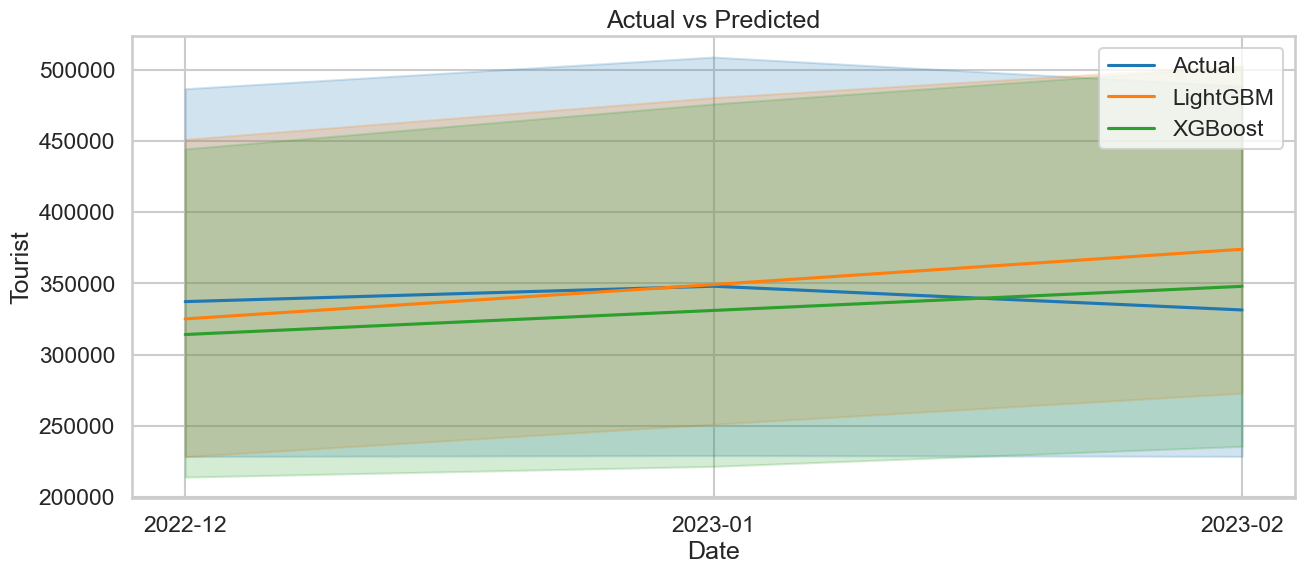

In [16]:
# plot actual vs predicted for each province
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style('whitegrid')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='date', y='y', data=merged_df, ax=ax, label='Actual')
sns.lineplot(x='date', y='LGBMRegressor', data=merged_df, ax=ax, label='LightGBM')
sns.lineplot(x='date', y='XGBRegressor', data=merged_df, ax=ax, label='XGBoost')
# x axis show only year-month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('Actual vs Predicted')
ax.set_ylabel('Tourist')
ax.set_xlabel('Date')
ax.legend()
plt.show()

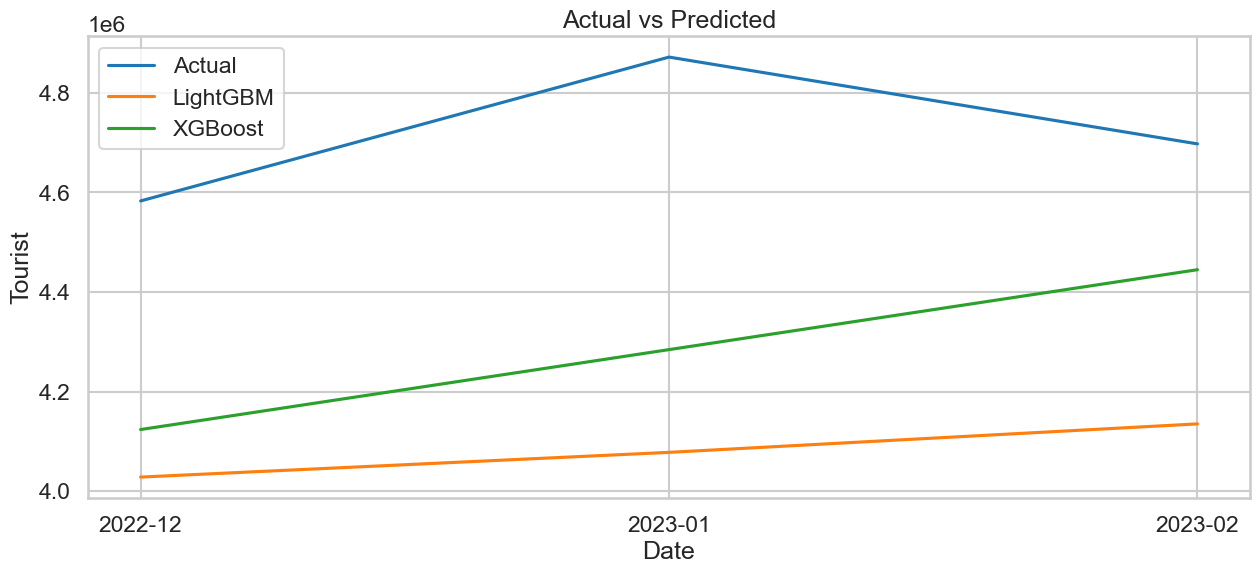

In [17]:
sns.set_style('whitegrid')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='date', y='y', data=merged_df[merged_df['province_eng'] == 'Bangkok'], ax=ax, label='Actual')
sns.lineplot(x='date', y='LGBMRegressor', data=merged_df[merged_df['province_eng'] == 'Bangkok'], ax=ax, label='LightGBM')
sns.lineplot(x='date', y='XGBRegressor', data=merged_df[merged_df['province_eng'] == 'Bangkok'], ax=ax, label='XGBoost')
ax.set_title('Actual vs Predicted')

# x axis show only year-month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_ylabel('Tourist')
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [18]:
merged_df[merged_df['province_eng'] == 'Bangkok']

,province_eng,date,LGBMRegressor,XGBRegressor,y
6,Bangkok,2022-12-01,4028152.94,4123694.0,4583029.0
7,Bangkok,2023-01-01,4077836.52,4284278.0,4872078.0
8,Bangkok,2023-02-01,4135051.49,4444862.0,4697654.0


## Nueral Network

In [19]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, LSTM
from neuralforecast.utils import AirPassengersDF

In [20]:
tourism_nl = tourism[['date', 'province_eng', 'no_tourist_all']]
tourism_nl = tourism_nl.rename(columns={'date': 'ds', 'province_eng': 'unique_id', 'no_tourist_all': 'y'})
tourism_nl['ds'] = pd.to_datetime(tourism_nl['ds'])
tourism_nl.sample(10)

,ds,unique_id,y
14,2019-01-01,Kamphaeng Phet,74421.0
36,2019-01-01,Pathum Thani,233295.0
225,2019-03-01,Ubon Ratchathani,281623.0
477,2019-07-01,Kanchanaburi,851628.0
1358,2020-06-01,Prachuap Khiri Khan,220118.0
459,2019-06-01,Uttaradit,64821.0
2567,2021-10-01,Nakhon Pathom,37242.0
2766,2021-12-01,Ubon Ratchathani,211200.0
3794,2023-02-01,Lopburi,244243.0
971,2020-01-01,Phuket,1722034.0


In [21]:
# get total runtime
import time
start_time = time.time()

Y_train_df = tourism_nl[tourism_nl.ds<'2022-12-01']
Y_test_df = tourism_nl[tourism_nl.ds>='2022-12-01']

# Fit and predict with N-BEATS and N-HITS models
horizon = Y_test_df.ds.nunique()
models = [NBEATS(max_epochs=50,input_size=2 * horizon, h=horizon),
		  NHITS(max_epochs=50,input_size=2 * horizon, h=horizon),
		  LSTM(max_epochs=200,
			   scaler_type='standard',
			   encoder_hidden_size=64,
			   decoder_hidden_size=64, h=horizon)]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)
print("--- %s seconds ---" % (time.time() - start_time))

Global seed set to 1
Global seed set to 1
Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

--- 67.07842111587524 seconds ---


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

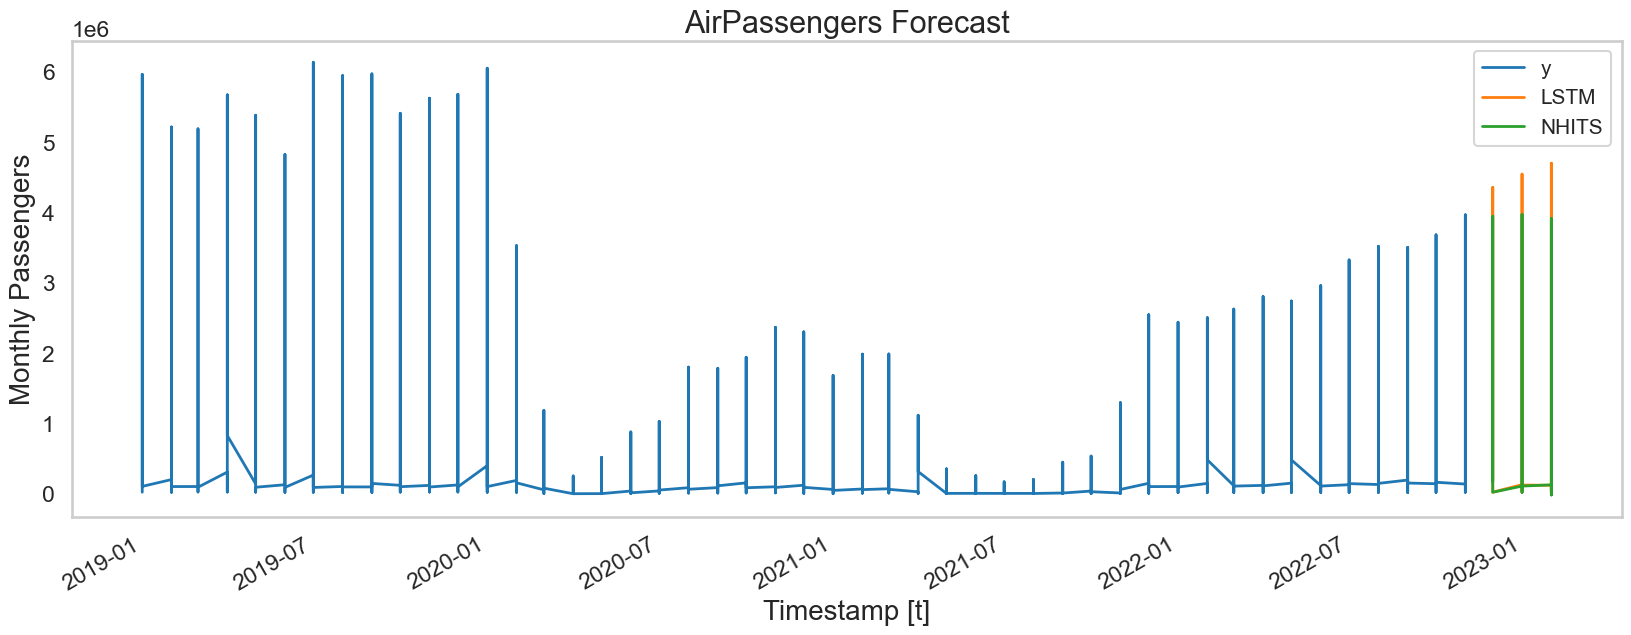

In [22]:
Y_hat_df = nf.predict().reset_index()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [23]:
Y_hat_df['ds'] = Y_hat_df['ds'].replace({'2022-11-30': '2022-12-01', '2022-12-31': '2023-01-01', '2023-01-31': '2023-02-01'})
Y_test_df['ds'] = Y_test_df['ds'].replace({'2022-11-30': '2022-12-01', '2022-12-31': '2023-01-01', '2023-01-31': '2023-02-01'})
Y_hat_df = Y_hat_df.rename(columns={'ds': 'date', 'unique_id': 'province_eng', 'y': 'y', 'NBEATS': 'NBEATS', 'NHITS': 'NHITS', 'LSTM': 'LSTM'})
Y_test_df = Y_test_df.rename(columns={'ds': 'date', 'unique_id': 'province_eng', 'y': 'y'})
merged_df = pd.merge(Y_hat_df, Y_test_df, on=['province_eng', 'date']).drop_duplicates()
dl_result = merged_df.copy()
merged_df

,province_eng,date,NBEATS,NHITS,LSTM,y
0,Amnat Charoen,2022-12-01,20753.310547,20510.699219,22344.474609,22573.0
1,Amnat Charoen,2023-01-01,20193.527344,20620.662109,22097.234375,23112.0
2,Amnat Charoen,2023-02-01,20260.210938,20235.628906,20597.763672,21896.0
3,Ang Thong,2022-12-01,54303.500000,57878.367188,65811.859375,64716.0
4,Ang Thong,2023-01-01,45792.089844,53404.335938,71843.000000,75492.0
...,...,...,...,...,...,...
226,Yala,2023-01-01,107434.460938,111717.179688,110593.531250,119386.0
227,Yala,2023-02-01,103695.148438,106651.867188,96019.671875,134064.0
228,Yasothon,2022-12-01,37846.531250,37438.609375,40926.507812,37251.0
229,Yasothon,2023-01-01,39253.875000,38640.050781,44595.835938,37655.0


In [24]:
nbeat_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['NBEATS']))
nbeat_mse = mean_squared_error(merged_df['y'], merged_df['NBEATS'])
nbeat_mape = np.mean(np.abs((merged_df['y'] - merged_df['NBEATS']) / merged_df['y'])) * 100
nbeat_smape = np.mean(np.abs((merged_df['y'] - merged_df['NBEATS']) / (merged_df['y'] + merged_df['NBEATS']))) * 100

nhit_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['NHITS']))
nhit_mse = mean_squared_error(merged_df['y'], merged_df['NHITS'])
nhit_mape = np.mean(np.abs((merged_df['y'] - merged_df['NHITS']) / merged_df['y'])) * 100
nhit_smape = np.mean(np.abs((merged_df['y'] - merged_df['NHITS']) / (merged_df['y'] + merged_df['NHITS']))) * 100

lstm_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['LSTM']))
lstm_mse = mean_squared_error(merged_df['y'], merged_df['LSTM'])
lstm_mape = np.mean(np.abs((merged_df['y'] - merged_df['LSTM']) / merged_df['y'])) * 100
lstm_smape = np.mean(np.abs((merged_df['y'] - merged_df['LSTM']) / (merged_df['y'] + merged_df['LSTM']))) * 100

print("NBEATS RMSE:", nbeat_rmse)
print("NBEATS MSE:", nbeat_mse)
print("NBEATS MAPE:", nbeat_mape)
print("NBEATS SMAPE:", nbeat_smape)
print("---------------------------")
print("NHITS RMSE:", nhit_rmse)
print("NHITS MSE:", nhit_mse)
print("NHITS MAPE:", nhit_mape)
print("NHITS SMAPE:", nhit_smape)
print("---------------------------")
print("LSTM RMSE:", lstm_rmse)
print("LSTM MSE:", lstm_mse)
print("LSTM MAPE:", lstm_mape)
print("LSTM SMAPE:", lstm_smape)

NBEATS RMSE: 133997.3262701351
NBEATS MSE: 17955283447.545033
NBEATS MAPE: 17.275635808407266
NBEATS SMAPE: 10.4246507188304
---------------------------
NHITS RMSE: 140427.8684629156
NHITS MSE: 19719986241.037926
NHITS MAPE: 16.741058465980103
NHITS SMAPE: 10.047490464585247
---------------------------
LSTM RMSE: 97068.89649813413
LSTM MSE: 9422370667.365477
LSTM MAPE: 13.395850767977272
LSTM SMAPE: 7.354940097168468


In [25]:
from statsforecast import StatsForecast

In [26]:
from statsforecast.models import (
	AutoARIMA,
	AutoETS,
	AutoTheta,
	DynamicOptimizedTheta,
	HistoricAverage
)

# Create a list of models and instantiation parameters
models = [
	AutoARIMA(season_length=12),
	AutoETS(season_length=12),
	AutoTheta(season_length=12),
	DynamicOptimizedTheta(season_length=12),
	HistoricAverage()
]

In [27]:
start_time = time.time()
# Instantiate StatsForecast class as sf
sf = StatsForecast(
	df=Y_train_df,
	models=models,
	freq='M',
	n_jobs=-1
)


In [28]:
start_time = time.time()
forecasts_df = sf.forecast(h=3)
forecasts_df.head()
print("--- %s seconds ---" % (time.time() - start_time))

--- 87.95019745826721 seconds ---


In [29]:
forecasts_df = forecasts_df.rename(columns={'ds': 'date', 'unique_id': 'province_eng'
	, 'y': 'y', 'AutoARIMA': 'AutoARIMA', 'AutoETS': 'AutoETS', 'AutoTheta': 'AutoTheta', 'DynamicOptimizedTheta': 'DynamicOptimizedTheta'})
forecasts_df

,date,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage
unique_id,,,,,,
Amnat Charoen,2022-11-30,31231.212891,20324.898438,20211.689453,20314.628906,16465.873047
Amnat Charoen,2022-12-31,25245.589844,20324.898438,20109.779297,20314.628906,16465.873047
Amnat Charoen,2023-01-31,20758.074219,20324.898438,20007.869141,20314.628906,16465.873047
Ang Thong,2022-11-30,57792.000000,57790.574219,57344.070312,57649.656250,43954.617188
Ang Thong,2022-12-31,57792.000000,57790.574219,57041.539062,57649.656250,43954.617188
...,...,...,...,...,...,...
Yala,2022-12-31,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531
Yala,2023-01-31,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531
Yasothon,2022-11-30,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375


In [30]:
forecasts_df['date'] = forecasts_df['date'].replace({'2022-11-30': '2022-12-01', '2022-12-31': '2023-01-01', '2023-01-31': '2023-02-01'})

In [31]:
forecasts_df = forecasts_df.reset_index()
forecasts_df.rename(columns={'unique_id': 'province_eng'}, inplace=True)

In [32]:
forecasts_df['date'] = forecasts_df['date'].replace({'2022-11-30': '2022-12-01', '2022-12-31': '2023-01-01', '2023-01-31': '2023-02-01'})
merged_df = pd.merge(forecasts_df, Y_test_df, on=['province_eng', 'date']).drop_duplicates()
merged_df

,province_eng,date,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage,y
0,Amnat Charoen,2022-12-01,31231.212891,20324.898438,20211.689453,20314.628906,16465.873047,22573.0
1,Amnat Charoen,2023-01-01,25245.589844,20324.898438,20109.779297,20314.628906,16465.873047,23112.0
2,Amnat Charoen,2023-02-01,20758.074219,20324.898438,20007.869141,20314.628906,16465.873047,21896.0
3,Ang Thong,2022-12-01,57792.000000,57790.574219,57344.070312,57649.656250,43954.617188,64716.0
4,Ang Thong,2023-01-01,57792.000000,57790.574219,57041.539062,57649.656250,43954.617188,75492.0
...,...,...,...,...,...,...,...,...
226,Yala,2023-01-01,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531,119386.0
227,Yala,2023-02-01,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531,134064.0
228,Yasothon,2022-12-01,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375,37251.0
229,Yasothon,2023-01-01,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375,37655.0


In [33]:
stat_results = merged_df.copy()

In [34]:
autoarima_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['AutoARIMA']))
autoarima_mse = mean_squared_error(merged_df['y'], merged_df['AutoARIMA'])
autoarima_mape = np.mean(np.abs((merged_df['y'] - merged_df['AutoARIMA']) / merged_df['y'])) * 100
autoarima_smape = np.mean(np.abs((merged_df['y'] - merged_df['AutoARIMA']) / (merged_df['y'] + merged_df['AutoARIMA']))) * 100

autoets_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['AutoETS']))
autoets_mse = mean_squared_error(merged_df['y'], merged_df['AutoETS'])
autoets_mape = np.mean(np.abs((merged_df['y'] - merged_df['AutoETS']) / merged_df['y'])) * 100
autoets_smape = np.mean(np.abs((merged_df['y'] - merged_df['AutoETS']) / (merged_df['y'] + merged_df['AutoETS']))) * 100

autotheta_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['AutoTheta']))
autotheta_mse = mean_squared_error(merged_df['y'], merged_df['AutoTheta'])
autotheta_mape = np.mean(np.abs((merged_df['y'] - merged_df['AutoTheta']) / merged_df['y'])) * 100
autotheta_smape = np.mean(np.abs((merged_df['y'] - merged_df['AutoTheta']) / (merged_df['y'] + merged_df['AutoTheta']))) * 100

dynamicoptimizedtheta_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['DynamicOptimizedTheta']))
dynamicoptimizedtheta_mse = mean_squared_error(merged_df['y'], merged_df['DynamicOptimizedTheta'])
dynamicoptimizedtheta_mape = np.mean(np.abs((merged_df['y'] - merged_df['DynamicOptimizedTheta']) / merged_df['y'])) * 100
dynamicoptimizedtheta_smape = np.mean(np.abs((merged_df['y'] - merged_df['DynamicOptimizedTheta']) / (merged_df['y'] + merged_df['DynamicOptimizedTheta']))) * 100

historicaverage_rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['HistoricAverage']))
historicaverage_mse = mean_squared_error(merged_df['y'], merged_df['HistoricAverage'])
historicaverage_mape = np.mean(np.abs((merged_df['y'] - merged_df['HistoricAverage']) / merged_df['y'])) * 100
historicaverage_smape = np.mean(np.abs((merged_df['y'] - merged_df['HistoricAverage']) / (merged_df['y'] + merged_df['HistoricAverage']))) * 100

print("AutoARIMA RMSE:", autoarima_rmse)
print("AutoARIMA MSE:", autoarima_mse)
print("AutoARIMA MAPE:", autoarima_mape)
print("AutoARIMA SMAPE:", autoarima_smape)
print("---------------------------")
print("AutoETS RMSE:", autoets_rmse)
print("AutoETS MSE:", autoets_mse)
print("AutoETS MAPE:", autoets_mape)
print("AutoETS SMAPE:", autoets_smape)
print("---------------------------")
print("AutoTheta RMSE:", autotheta_rmse)
print("AutoTheta MSE:", autotheta_mse)
print("AutoTheta MAPE:", autotheta_mape)
print("AutoTheta SMAPE:", autotheta_smape)
print("---------------------------")
print("DynamicOptimizedTheta RMSE:", dynamicoptimizedtheta_rmse)
print("DynamicOptimizedTheta MSE:", dynamicoptimizedtheta_mse)
print("DynamicOptimizedTheta MAPE:", dynamicoptimizedtheta_mape)
print("DynamicOptimizedTheta SMAPE:", dynamicoptimizedtheta_smape)
print("---------------------------")
print("HistoricAverage RMSE:", historicaverage_rmse)
print("HistoricAverage MSE:", historicaverage_mse)
print("HistoricAverage MAPE:", historicaverage_mape)
print("HistoricAverage SMAPE:", historicaverage_smape)

AutoARIMA RMSE: 142678.09604977857
AutoARIMA MSE: 20357039092.38984
AutoARIMA MAPE: 18.726599171091245
AutoARIMA SMAPE: 11.485020217759054
---------------------------
AutoETS RMSE: 121817.72844213249
AutoETS MSE: 14839558962.801136
AutoETS MAPE: 13.338847212252425
AutoETS SMAPE: 7.51330941428441
---------------------------
AutoTheta RMSE: 121916.23463292656
AutoTheta MSE: 14863568267.0708
AutoTheta MAPE: 13.66748910527232
AutoTheta SMAPE: 7.690522798744862
---------------------------
DynamicOptimizedTheta RMSE: 114069.54684307471
DynamicOptimizedTheta MSE: 13011861516.984415
DynamicOptimizedTheta MAPE: 12.822490159048
DynamicOptimizedTheta SMAPE: 7.120290467835204
---------------------------
HistoricAverage RMSE: 296334.9661740151
HistoricAverage MSE: 87814412177.35468
HistoricAverage MAPE: 36.81226719552511
HistoricAverage SMAPE: 23.456586161769653


In [117]:
# compare every method xgboost, lightgbm, nbeats, nhits, ltsm, autoarima, autoets, autotheta, dynamicoptimizedtheta mse, mape, smape, rmse

compare_df = pd.DataFrame({'model': ['xgboost', 'lightgbm', 'nbeats', 'nhits', 'ltsm', 'autoarima', 'autoets', 'autotheta', 'dynamicoptimizedtheta', 'historicaverage'],
	'rmse': [xgb_rmse, lgb_rmse, nbeat_rmse, nhit_rmse, lstm_rmse, autoarima_rmse, autoets_rmse, autotheta_rmse, dynamicoptimizedtheta_rmse, historicaverage_rmse],
	'mse': [xgb_mse, lgb_mse, nbeat_mse, nhit_mse, lstm_mse, autoarima_mse, autoets_mse, autotheta_mse, dynamicoptimizedtheta_mse, historicaverage_mse],
	'mape': [xgb_mape, lgb_mape, nbeat_mape, nhit_mape, lstm_mape, autoarima_mape, autoets_mape, autotheta_mape, dynamicoptimizedtheta_mape, historicaverage_mape],
	'smape': [xgb_smape, lgb_smape, nbeat_smape, nhit_smape, lstm_smape, autoarima_smape, autoets_smape, autotheta_smape, dynamicoptimizedtheta_smape, historicaverage_smape]})

compare_df

,model,rmse,mse,mape,smape
0,xgboost,85862.979967,7.372451e+09,11.857988,11.879634
1,lightgbm,98577.111209,9.717447e+09,23.946181,20.170576
2,nbeats,133997.326270,1.795528e+10,17.275636,10.424651
3,nhits,140427.868463,1.971999e+10,16.741058,10.047490
4,ltsm,97068.896498,9.422371e+09,13.395851,7.354940
5,autoarima,142678.096050,2.035704e+10,18.726599,11.485020
6,autoets,121817.728442,1.483956e+10,13.338847,7.513309
7,autotheta,121916.234633,1.486357e+10,13.667489,7.690523
8,dynamicoptimizedtheta,114069.546843,1.301186e+10,12.822490,7.120290
9,historicaverage,296334.966174,8.781441e+10,36.812267,23.456586


In [119]:
# add time column if xgboost lgihtgbm then "20-30 sec"
# if nbeats nhits lstm then "1-2 min"
# if autoarima autoets autotheta dynamicoptimizedtheta then "1 mins"

compare_df['time'] = ['30 sec', '20 sec', '1-2 mins', '1-2 mins', '1-2 mins', '3 mins', '1 mins', '1 mins', '1 mins', '5 sec']
compare_df

# add method type column if xgboost lgihtgbm then "machine learning"
# if nbeats nhits lstm then "deep learning"
# if autoarima autoets autotheta dynamicoptimizedtheta then "statistical"

compare_df['method_type'] = ['machine learning', 'machine learning', 'deep learning', 'deep learning', 'deep learning', 'statistical', 'statistical', 'statistical', 'statistical', 'baseline']
compare_df

,model,rmse,mse,mape,smape,time,method_type
0,xgboost,85862.979967,7.372451e+09,11.857988,11.879634,30 sec,machine learning
1,lightgbm,98577.111209,9.717447e+09,23.946181,20.170576,20 sec,machine learning
2,nbeats,133997.326270,1.795528e+10,17.275636,10.424651,1-2 mins,deep learning
3,nhits,140427.868463,1.971999e+10,16.741058,10.047490,1-2 mins,deep learning
4,ltsm,97068.896498,9.422371e+09,13.395851,7.354940,1-2 mins,deep learning
5,autoarima,142678.096050,2.035704e+10,18.726599,11.485020,3 mins,statistical
6,autoets,121817.728442,1.483956e+10,13.338847,7.513309,1 mins,statistical
7,autotheta,121916.234633,1.486357e+10,13.667489,7.690523,1 mins,statistical
8,dynamicoptimizedtheta,114069.546843,1.301186e+10,12.822490,7.120290,1 mins,statistical
9,historicaverage,296334.966174,8.781441e+10,36.812267,23.456586,5 sec,baseline


In [121]:
compare_df.to_csv('compare_df.csv', index=False)

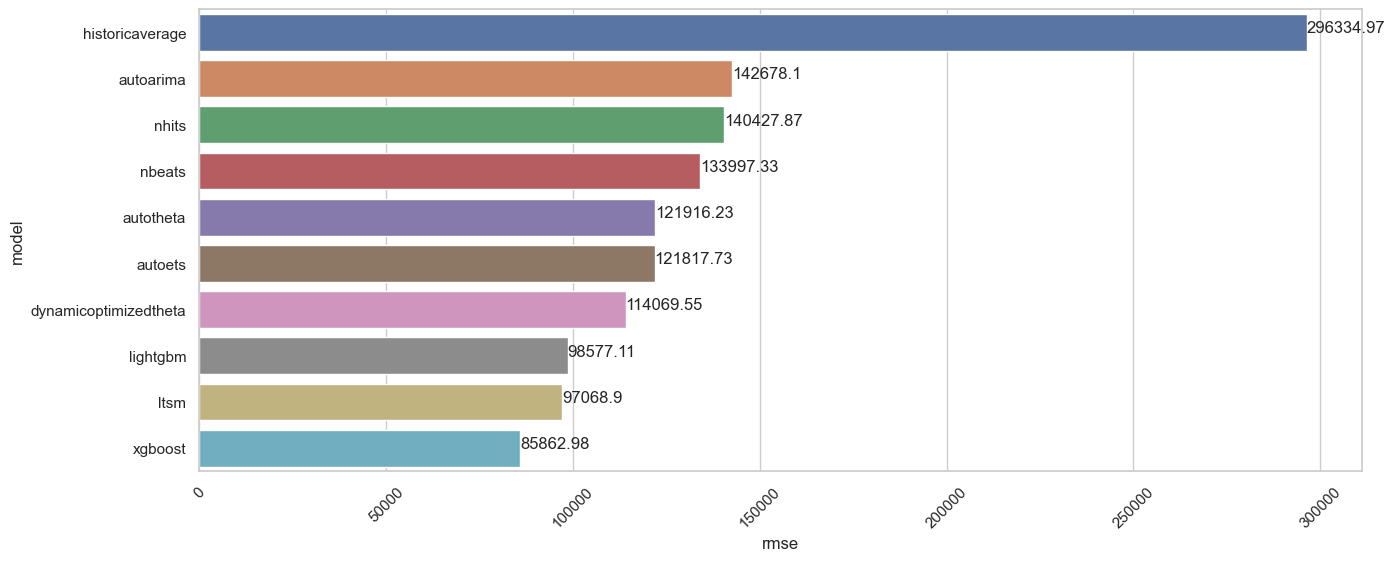

In [43]:
# plot barplot for every method compare_df
# white background

plt.figure(figsize=(15, 6))
# white theme
#sort by rmse
compare_df = compare_df.sort_values(by='rmse', ascending=False)
sns.set_theme(style="whitegrid")
sns.barplot(data=compare_df, y='model', x='rmse')
for index, value in enumerate(compare_df['rmse']):
	plt.text(value, index, str(round(value, 2)))
plt.xticks(rotation=45)
plt.show()

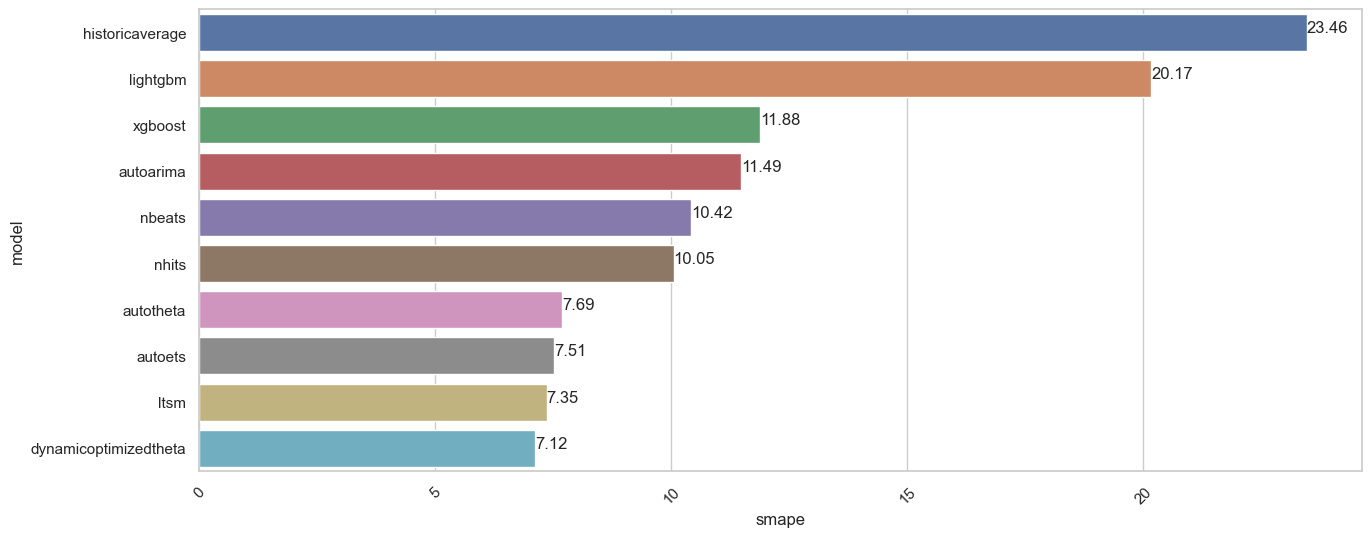

In [42]:
plt.figure(figsize=(15, 6))
# white theme
#sort by rmse
compare_df = compare_df.sort_values(by='smape', ascending=False)
sns.set_theme(style="whitegrid")
sns.barplot(data=compare_df, y='model', x='smape')
# with number
for index, value in enumerate(compare_df['smape']):
	plt.text(value, index, str(round(value, 2)))
plt.xticks(rotation=45)
plt.show()

In [112]:
# pandas float format
pd.options.display.float_format = '{:.2f}'.format
compare_df

In [71]:
# save compare_df to csv
compare_df.to_csv('compare_df.csv', index=False)

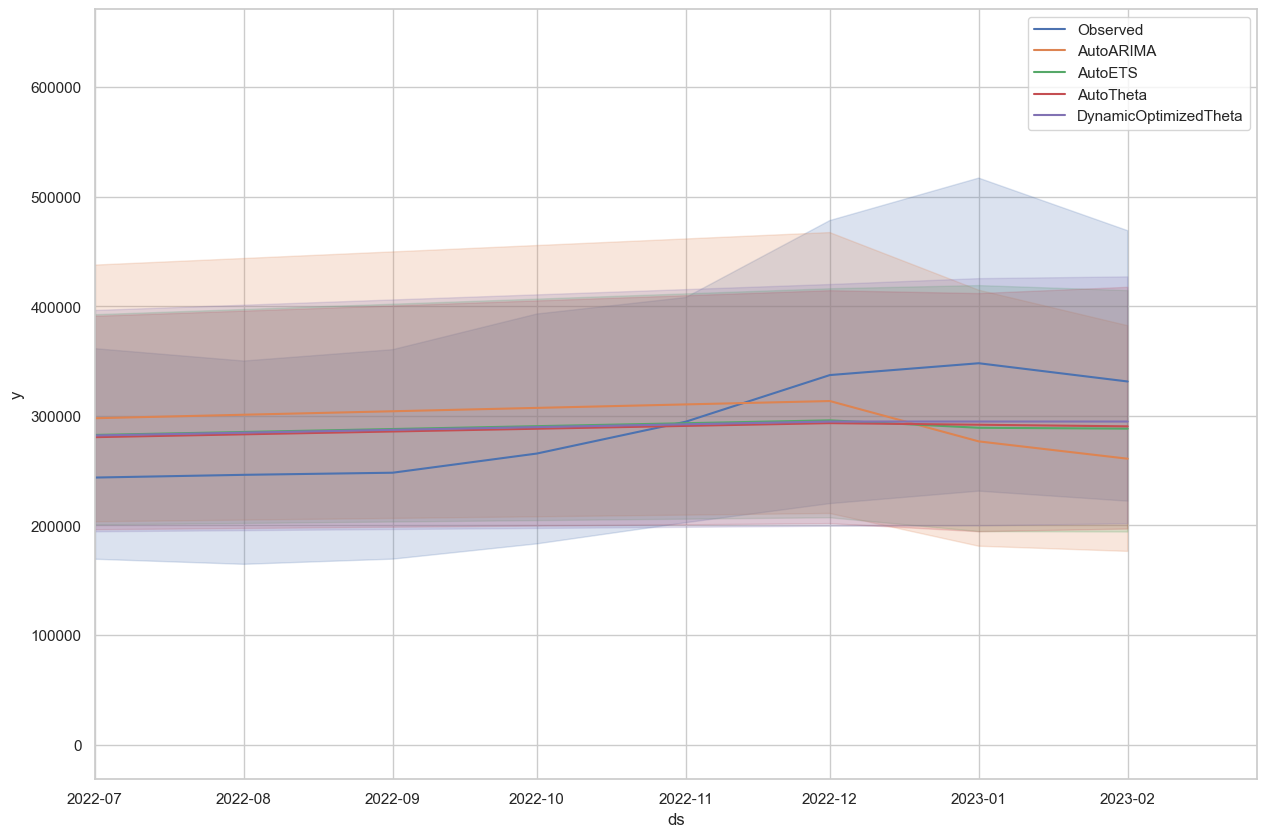

In [98]:
# seaborn lineplot all
plot_df = pd.concat([Y_train_df, merged_df.rename(columns={'date': 'ds', 'province_eng':'unique_id'})])
# white background

plt.figure(figsize=(15, 10))
# white theme
sns.set_theme(style="whitegrid")
sns.lineplot(data=plot_df, x='ds', y='y', label='Observed')
sns.lineplot(data=plot_df, x='ds', y='AutoARIMA', label='AutoARIMA')
sns.lineplot(data=plot_df, x='ds', y='AutoETS', label='AutoETS')
sns.lineplot(data=plot_df, x='ds', y='AutoTheta', label='AutoTheta')
sns.lineplot(data=plot_df, x='ds', y='DynamicOptimizedTheta', label='DynamicOptimizedTheta')
plt.legend(loc='best')
# filter x axis
plt.xlim([datetime.date(2022, 7, 1), datetime.date(2023, 2, 28)])
plt.show()

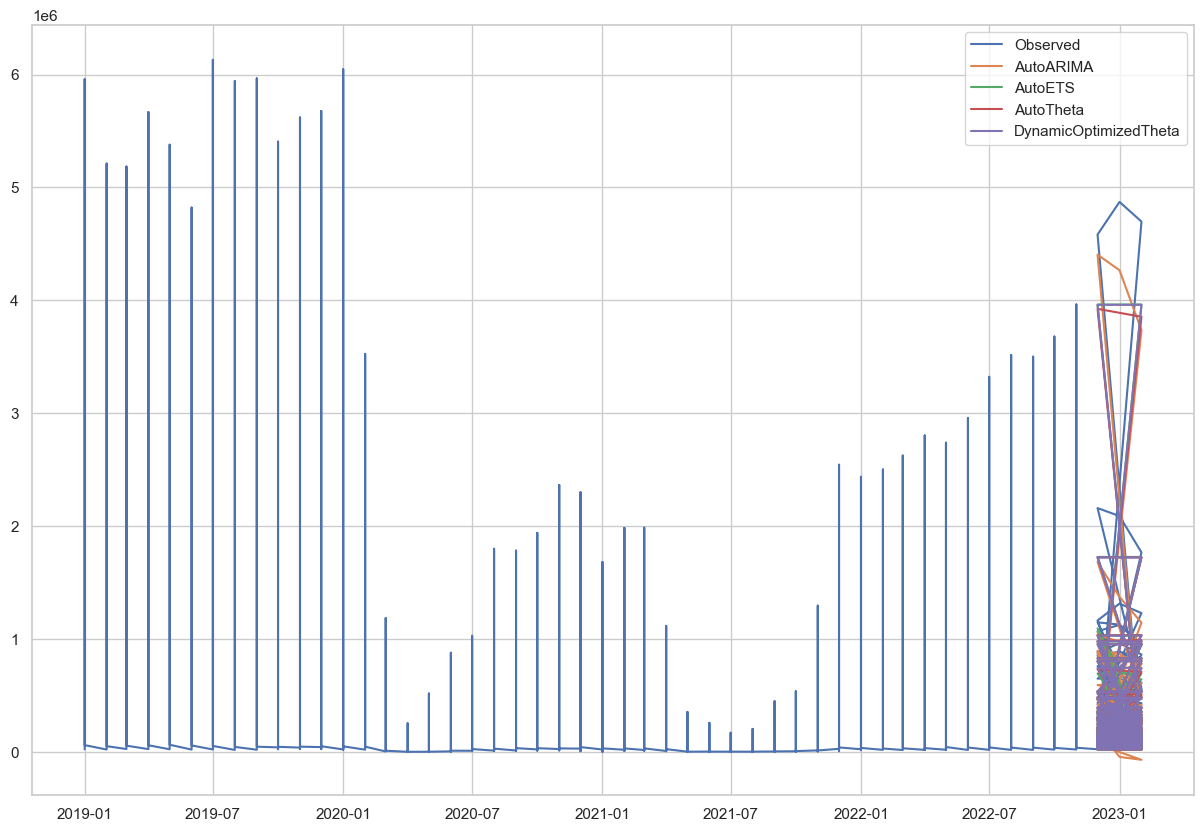

In [115]:
all = pd.concat([Y_train_df, merged_df.rename(columns={'date': 'ds', 'province_eng':'unique_id'})])
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(all['ds'], all['y'], label='Observed')
plt.plot(all['ds'], all['AutoARIMA'], label='AutoARIMA')
plt.plot(all['ds'], all['AutoETS'], label='AutoETS')
plt.plot(all['ds'], all['AutoTheta'], label='AutoTheta')
plt.plot(all['ds'], all['DynamicOptimizedTheta'], label='DynamicOptimizedTheta')
plt.legend(loc='best')
plt.show()

In [82]:
all_method = ml_result.merge(dl_result.drop("y", axis=1), on=['province_eng', 'date'], how='inner')
all_method = all_method.merge(stat_results, on=['province_eng', 'date'], how='inner')
all_method

,province_eng,date,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage,y
0,Amnat Charoen,2022-12-01,36805.03,23215.79,20753.310547,20510.699219,22344.474609,31231.212891,20324.898438,20211.689453,20314.628906,16465.873047,22573.0
1,Amnat Charoen,2023-01-01,44314.73,23724.98,20193.527344,20620.662109,22097.234375,25245.589844,20324.898438,20109.779297,20314.628906,16465.873047,23112.0
2,Amnat Charoen,2023-02-01,52726.36,24056.32,20260.210938,20235.628906,20597.763672,20758.074219,20324.898438,20007.869141,20314.628906,16465.873047,21896.0
3,Ang Thong,2022-12-01,73377.14,64159.32,54303.500000,57878.367188,65811.859375,57792.000000,57790.574219,57344.070312,57649.656250,43954.617188,64716.0
4,Ang Thong,2023-01-01,90617.02,74032.54,45792.089844,53404.335938,71843.000000,57792.000000,57790.574219,57041.539062,57649.656250,43954.617188,75492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Yala,2023-01-01,172261.81,111554.34,107434.460938,111717.179688,110593.531250,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531,119386.0
227,Yala,2023-02-01,196400.94,102905.05,103695.148438,106651.867188,96019.671875,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531,134064.0
228,Yasothon,2022-12-01,52878.18,35336.93,37846.531250,37438.609375,40926.507812,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375,37251.0
229,Yasothon,2023-01-01,62196.18,34820.07,39253.875000,38640.050781,44595.835938,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375,37655.0


In [84]:
gg = Y_train_df.copy()
gg.columns = ['date', 'province_eng', 'y']
all_method = pd.concat([gg, all_method])

In [85]:
all_method

,date,province_eng,y,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage
0,2019-01-01,Amnat Charoen,21790.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Ang Thong,104097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Bangkok,5959075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Bueng Kan,65978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Buriram,185563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2023-01-01,Yala,119386.0,172261.81,111554.34,107434.460938,111717.179688,110593.531250,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531
227,2023-02-01,Yala,134064.0,196400.94,102905.05,103695.148438,106651.867188,96019.671875,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531
228,2022-12-01,Yasothon,37251.0,52878.18,35336.93,37846.531250,37438.609375,40926.507812,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375
229,2023-01-01,Yasothon,37655.0,62196.18,34820.07,39253.875000,38640.050781,44595.835938,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375


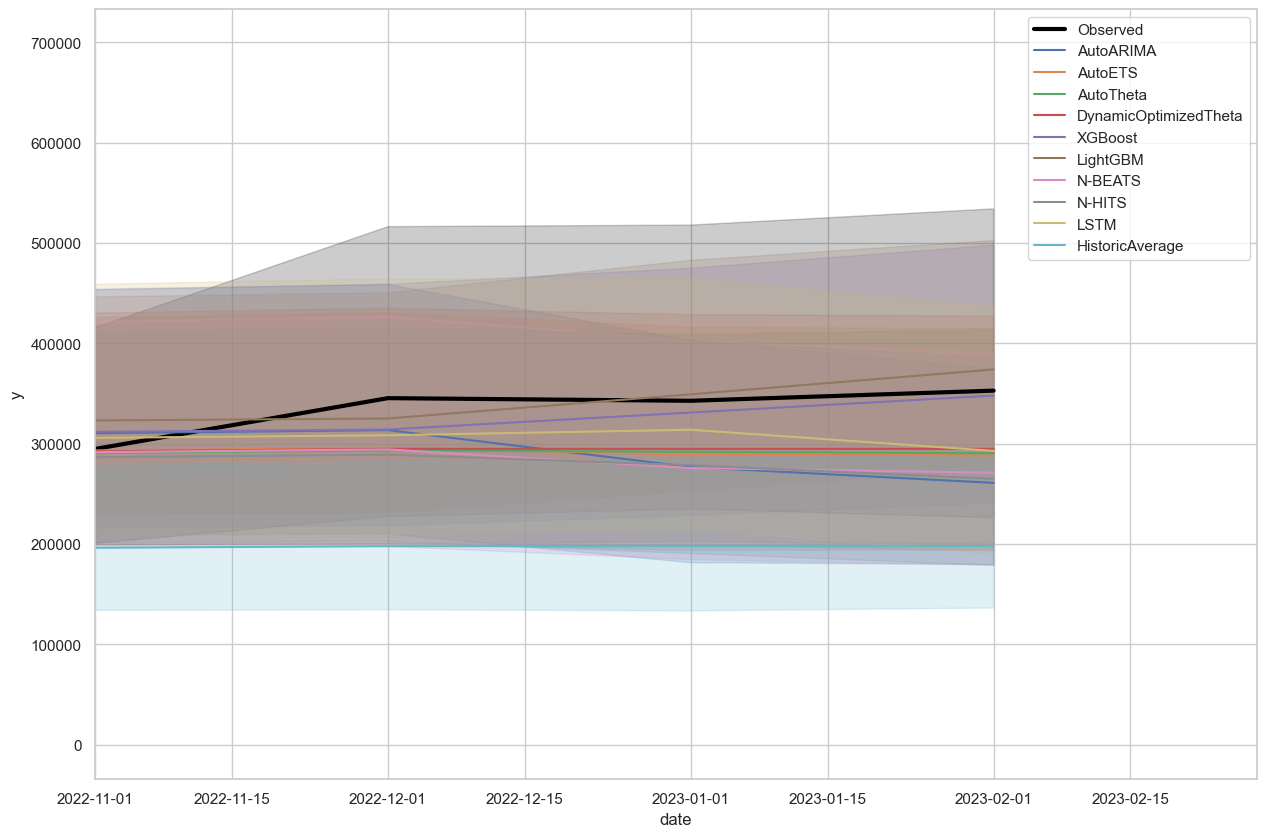

In [78]:
# plot lineplot for every method all_method
# white background

plt.figure(figsize=(15, 10))
# white theme
sns.set_theme(style="whitegrid")
sns.lineplot(data=all_method, x='date', y='y', label='Observed', color='black', linewidth=3)
sns.lineplot(data=all_method, x='date', y='AutoARIMA', label='AutoARIMA')
sns.lineplot(data=all_method, x='date', y='AutoETS', label='AutoETS')
sns.lineplot(data=all_method, x='date', y='AutoTheta', label='AutoTheta')
sns.lineplot(data=all_method, x='date', y='DynamicOptimizedTheta', label='DynamicOptimizedTheta')
sns.lineplot(data=all_method, x='date', y='XGBRegressor', label='XGBoost')
sns.lineplot(data=all_method, x='date', y='LGBMRegressor', label='LightGBM')
sns.lineplot(data=all_method, x='date', y='NBEATS', label='N-BEATS')
sns.lineplot(data=all_method, x='date', y='NHITS', label='N-HITS')
sns.lineplot(data=all_method, x='date', y='LSTM', label='LSTM')
sns.lineplot(data=all_method, x='date', y='HistoricAverage', label='HistoricAverage')

plt.legend(loc='best')
# filter x axis
plt.xlim([datetime.date(2022, 11, 1), datetime.date(2023, 2, 28)])
plt.show()

In [96]:
# province_eng that contain ket
all_method[all_method['province_eng'].str.contains('uket')]

,date,province_eng,y,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage
47,2019-01-01,Phuket,1690776.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,2019-02-01,Phuket,1522828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,2019-03-01,Phuket,1645784.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,2019-04-01,Phuket,1283781.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,2019-05-01,Phuket,930340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,2019-06-01,Phuket,1181192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,2019-07-01,Phuket,811130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,2019-08-01,Phuket,794213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,2019-09-01,Phuket,834314.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,2019-10-01,Phuket,1156536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
all_method[all_method['province_eng'] == 'Phuket']

,date,province_eng,y,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage


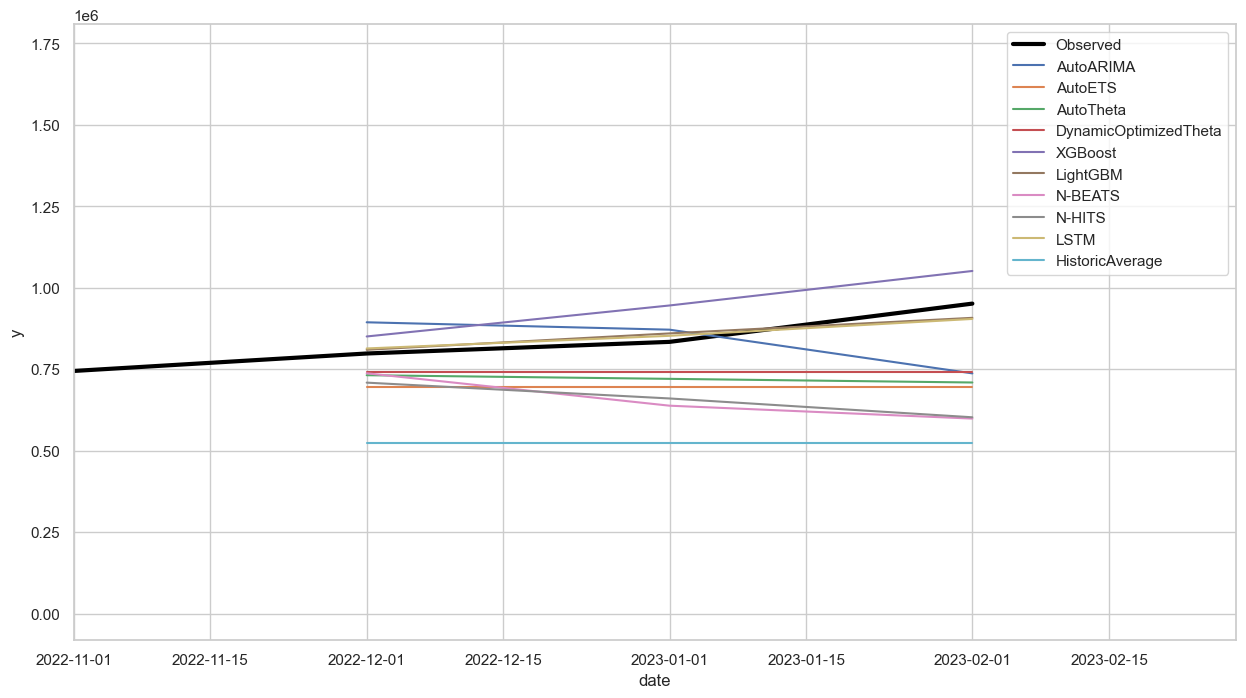

In [97]:
# plot lineplot for every method all_method for Bangkok
# white background

plt.figure(figsize=(15, 8))
# white theme
sns.set_theme(style="whitegrid")
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='y', label='Observed', color='black', linewidth=3)
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='AutoARIMA', label='AutoARIMA')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='AutoETS', label='AutoETS')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='AutoTheta', label='AutoTheta')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='DynamicOptimizedTheta', label='DynamicOptimizedTheta')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='XGBRegressor', label='XGBoost')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='LGBMRegressor', label='LightGBM')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='NBEATS', label='N-BEATS')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='NHITS', label='N-HITS')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='LSTM', label='LSTM')
sns.lineplot(data=all_method[all_method['province_eng'].str.contains('uket')], x='date', y='HistoricAverage', label='HistoricAverage')

plt.legend(loc='best')
# filter x axis
plt.xlim([datetime.date(2022, 11, 1), datetime.date(2023, 2, 28)])
plt.show()

In [ ]:


axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['y'], label='Observed', color='black', linewidth=3)
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['AutoARIMA'], label='AutoARIMA')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['AutoETS'], label='AutoETS')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['AutoTheta'], label='AutoTheta')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['DynamicOptimizedTheta'], label='DynamicOptimizedTheta')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['XGBRegressor'], label='XGBoost')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['LGBMRegressor'], label='LightGBM')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['NBEATS'], label='N-BEATS')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['NHITS'], label='N-HITS')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['LSTM'], label='LSTM')
axs[0, 1].plot(all_method[all_method['province_eng'].str.contains('Amnat Charoen')]['date'], all_method[all_method['province_eng'].str.contains('angkok')]['HistoricAverage'], label='HistoricAverage')
axs[0, 1].set_title('Amnat Charoen')


In [99]:
def plot_province(province_name):
	plt.figure(figsize=(15, 8))
	# white theme
	sns.set_theme(style="whitegrid")
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='y', label='Observed', color='black', linewidth=3)
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='AutoARIMA', label='AutoARIMA')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='AutoETS', label='AutoETS')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='AutoTheta', label='AutoTheta')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='DynamicOptimizedTheta', label='DynamicOptimizedTheta')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='XGBRegressor', label='XGBoost')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='LGBMRegressor', label='LightGBM')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='NBEATS', label='N-BEATS')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='NHITS', label='N-HITS')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='LSTM', label='LSTM')
	sns.lineplot(data=all_method[all_method['province_eng'].str.contains(province_name)], x='date', y='HistoricAverage', label='HistoricAverage')

	plt.legend(loc='best')
	# filter x axis
	plt.xlim([datetime.date(2022, 11, 1), datetime.date(2023, 2, 28)])
	plt.show()

In [123]:
all_method

,date,province_eng,y,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage
0,2019-01-01,Amnat Charoen,21790.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Ang Thong,104097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Bangkok,5959075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Bueng Kan,65978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Buriram,185563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2023-01-01,Yala,119386.0,172261.81,111554.34,107434.460938,111717.179688,110593.531250,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531
227,2023-02-01,Yala,134064.0,196400.94,102905.05,103695.148438,106651.867188,96019.671875,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531
228,2022-12-01,Yasothon,37251.0,52878.18,35336.93,37846.531250,37438.609375,40926.507812,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375
229,2023-01-01,Yasothon,37655.0,62196.18,34820.07,39253.875000,38640.050781,44595.835938,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375


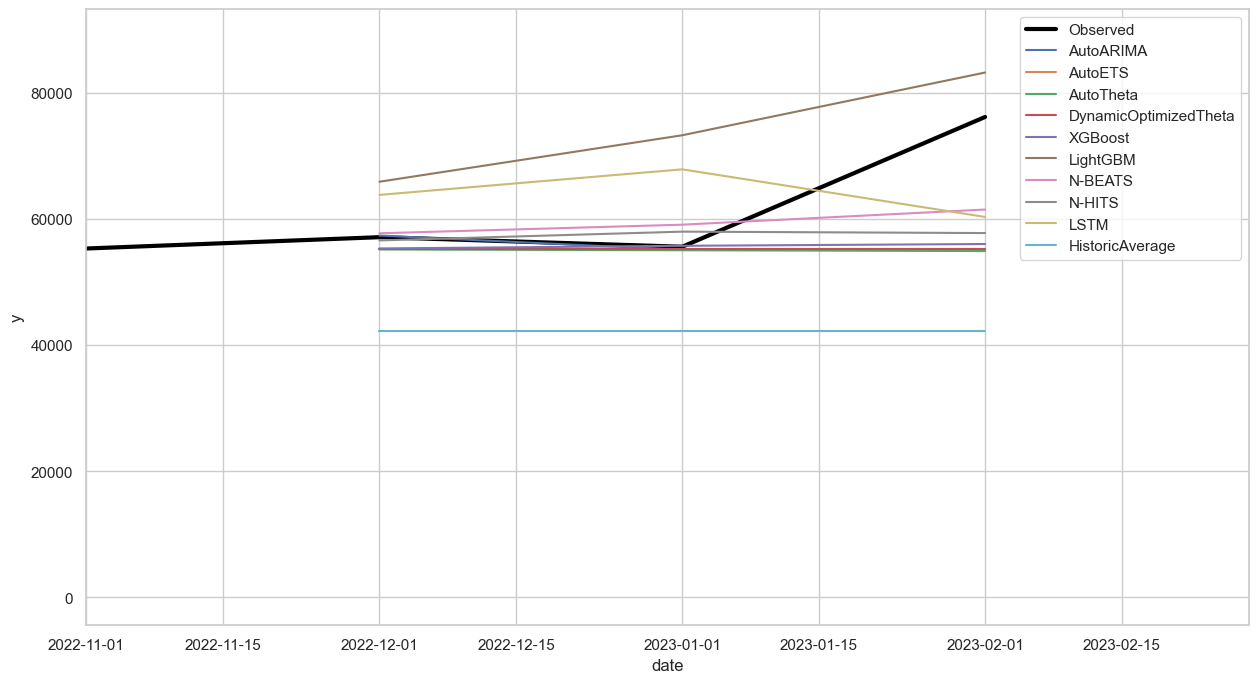

In [127]:
plot_province('Kanchanaburi')

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

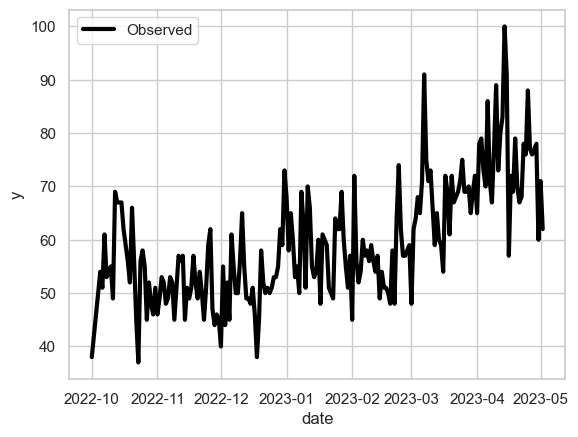

In [114]:
phuket = pd.read_clipboard()
phuket.columns = ['date', 'y']
phuket['date'] = pd.to_datetime(phuket['date'])
phuket
# plot trend line of phuket
# white theme
sns.set_theme(style="whitegrid")
sns.lineplot(data=phuket, x='date', y='y', label='Observed', color='black', linewidth=3)
# add trend line
sns.regplot(data=phuket, x='date', y='y', scatter=False, label='Trend')
plt.legend(loc='best')
# filter x axis
plt.xlim([datetime.date(2022, 11, 1), datetime.date(2023, 2, 28)])
plt.show()

In [102]:
all_method

,date,province_eng,y,LGBMRegressor,XGBRegressor,NBEATS,NHITS,LSTM,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage
0,2019-01-01,Amnat Charoen,21790.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Ang Thong,104097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Bangkok,5959075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Bueng Kan,65978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Buriram,185563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2023-01-01,Yala,119386.0,172261.81,111554.34,107434.460938,111717.179688,110593.531250,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531
227,2023-02-01,Yala,134064.0,196400.94,102905.05,103695.148438,106651.867188,96019.671875,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531
228,2022-12-01,Yasothon,37251.0,52878.18,35336.93,37846.531250,37438.609375,40926.507812,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375
229,2023-01-01,Yasothon,37655.0,62196.18,34820.07,39253.875000,38640.050781,44595.835938,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375


In [48]:
stat_results

,province_eng,date,AutoARIMA,AutoETS,AutoTheta,DynamicOptimizedTheta,HistoricAverage,y
0,Amnat Charoen,2022-12-01,31231.212891,20324.898438,20211.689453,20314.628906,16465.873047,22573.0
1,Amnat Charoen,2023-01-01,25245.589844,20324.898438,20109.779297,20314.628906,16465.873047,23112.0
2,Amnat Charoen,2023-02-01,20758.074219,20324.898438,20007.869141,20314.628906,16465.873047,21896.0
3,Ang Thong,2022-12-01,57792.000000,57790.574219,57344.070312,57649.656250,43954.617188,64716.0
4,Ang Thong,2023-01-01,57792.000000,57790.574219,57041.539062,57649.656250,43954.617188,75492.0
...,...,...,...,...,...,...,...,...
226,Yala,2023-01-01,113248.289062,121118.421875,122225.390625,121060.140625,48031.019531,119386.0
227,Yala,2023-02-01,109506.859375,121118.421875,122805.085938,121060.140625,48031.019531,134064.0
228,Yasothon,2022-12-01,36051.000000,36050.933594,35783.996094,36044.664062,31931.234375,37251.0
229,Yasothon,2023-01-01,36051.000000,36050.933594,35525.933594,36044.664062,31931.234375,37655.0
